In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import scipy.stats
import seaborn as sns

Data_path = 'Data/'

In [2]:
# Keeping only relevant features
features_df = pd.read_csv(Data_path+'nodes_attributes.csv',index_col=0)
features_df.drop(columns = ['title','id','ceremony_year'],inplace = True)

In [3]:
features_df.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,Oscars,Nominations_Oscars,GoldenGlobes,Nominations_GoldenGlobes
0,237000000,150.437577,2787965087,162.0,7.2,11800,3.0,9.0,2.0,4.0
1,300000000,139.082615,961000000,169.0,6.9,4500,0.0,2.0,0.0,0.0
2,245000000,107.376788,880674609,148.0,6.3,4466,1.0,1.0,1.0,1.0
3,250000000,112.312950,1084939099,165.0,7.6,9106,0.0,0.0,0.0,0.0
4,260000000,43.926995,284139100,132.0,6.1,2124,0.0,0.0,0.0,0.0


# Classes ratio

In [4]:
# Determination of the percentage of nodes that have oscars or nominations (to show class imbalance)

oscars_count = features_df['Oscars'].value_counts()
oscars_fraction = (np.sum(oscars_count) - oscars_count[0])/np.sum(oscars_count)

nominations_count = features_df['Nominations_Oscars'].value_counts()
nominations_fraction = (np.sum(nominations_count) - nominations_count[0])/np.sum(nominations_count)

print(f"Percentage of movies having one or more Oscars: {oscars_fraction:.3f}")
print(f"Percentage of movies having one or more Nominations: {nominations_fraction:.3f}")

Percentage of movies having one or more Oscars: 0.067
Percentage of movies having one or more Nominations: 0.178


# Spearman correlation 

In [5]:
# We do not know if our data are linearly related (assumption behind Pearson), that's why we use Spearman coefficient
# which is a statistical measure of the strength of a monotonic relationship between paired data

# We compute it between oscars (or nominations) and budget, popularity, revenue, runtime, vote average, vote count

corr_df = features_df.corr(method = 'spearman').loc[:,['Oscars','Nominations_Oscars']]

# To remove meaningless information (correlation between labels)
corr_df = corr_df.drop(['Oscars','Nominations_Oscars']) 

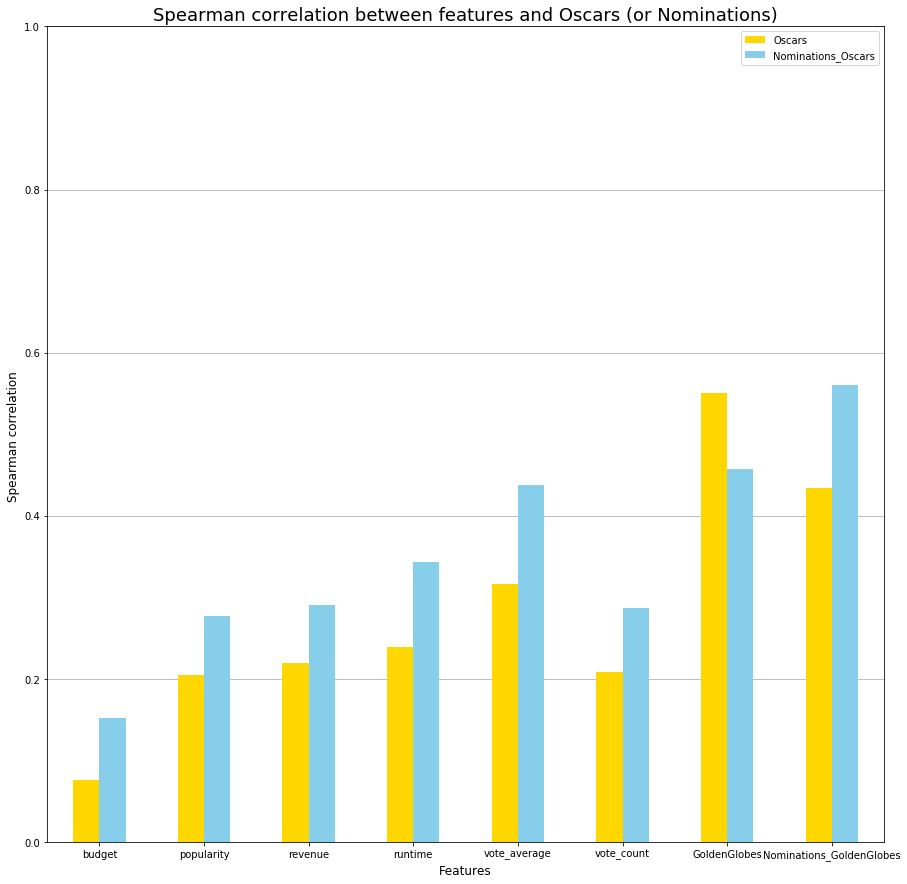

In [6]:
# Bar plots to visualize Spearman correlation
ax = corr_df.plot.bar(rot=0,figsize=(15,15),color=['gold','skyblue'])

ax.set_title("Spearman correlation between features and Oscars (or Nominations)",size=18)
ax.set_ylim([0, 1])
ax.set_xlabel("Features",size=12)
ax.set_ylabel("Spearman correlation ",size=12)
ax.grid(True, which='major', axis='y')
ax.set_axisbelow(True)
plt.show()

# Similarity matrices exploration

In [ ]:
# Loading similarity matrices previously computed
sim_mat = {}
feat_names = ['Genre','Keywords', 'Crew', 'Cast']
for name in feat_names:
    with open(Data_path+'csim_'+name, 'rb') as src:
        sim_mat[name] = pickle.load(src)
        print(f'>>> Loading {name} similarity matrix with shape {sim_mat[name].shape}')

In [ ]:
# Four separate graphs
fig, axs = plt.subplots(2, 2,figsize=(10, 10))
adj_mat = sim_mat.values()
for name, mat, ax in zip(feat_names, adj_mat, axs.reshape(-1)):
    ax.hist(mat.values.ravel(), log=True, bins=50,color='royalblue')
    ax.set_title(name,size=15)
    ax.set_xlabel('Scaled Cosine Similarity',size=12)
    ax.set_ylabel('Log scaled quantity',size=12)
plt.show()